In [1]:
import math
import copy
import random
import numpy as np
import pickle
import heapq
import matplotlib.pyplot as plt

In [2]:
def gridToImage(grid, color_dict):
    grid = copy.deepcopy(grid)
    for row in grid:
        for i in range(len(row)):
            row[i] = color_dict.get(row[i], [0, row[i], 0])
    plt.imshow(grid)
    plt.show()

def showPath(start, end, grid, path):
    grid = copy.deepcopy(grid)
    for n in path:
        grid[n[1]][n[0]] = 7

    grid[start[1]][start[0]] = 'S'
    grid[end[1]][end[0]] = 'E'

    color_dict = {
        0 : [255, 255, 255],
        1 : [0, 0, 0],
        7 : [0, 255, 0],
        'S' : [0, 0, 255],
        'E' : [255, 0, 0]
    }

    gridToImage(grid, color_dict)

def showValues(start, end, grid):
    grid = copy.deepcopy(grid)
    max_value = max([max(row) for row in grid])
    for row in grid:
        for i in range(len(row)):
            if isinstance(row[i], int) and row[i] == 1:
                row[i] = 'O'
            elif isinstance(row[i], float):
                row[i] /= max_value

    grid[start[1]][start[0]] = 'S'
    grid[end[1]][end[0]] = 'E'

    color_dict = {
        0 : [255, 255, 255],
        'O' : [0, 0, 0],
        7 : [0, 255, 0],
        'S' : [0, 0, 255],
        'E' : [255, 0, 0]
    }

    gridToImage(grid, color_dict)

In [3]:
class Node:

    def __init__(self, pos, parent=None):
        self.pos = tuple(pos)
        self.parent = parent
        self.g = 0 # cost of path from n to start
        self.h = 0 # estimated cost of path from n to end
        self.f = 0 # total cost = g + h

    def __eq__(self, other):
        return self.pos[0] == other.pos[0] and self.pos[1] == other.pos[1]
    
    def __hash__(self):
        return hash(self.pos)
    

In [4]:
import heapq

In [5]:
def create_cost_grid(grid, costs):
    new_grid = copy.deepcopy(grid)

    check_range = len(costs)
    costs.insert(0, -1)
    for r in range(len(grid)):
        for c in range(len(grid[0])):
            if grid[r][c] == 1:
                if c == 0 or grid[r][c - 1] == 1:
                    left_check = 0
                else:
                    left_check = -check_range

                if c == len(grid[0]) - 1 or grid[r][c + 1] == 1:
                    right_check = 0
                else:
                    right_check = check_range

                if r == len(grid) - 1 or grid[r + 1][c] == 1:
                    up_check = 0
                else:
                    up_check = check_range

                if r == 0 or grid[r - 1][c] == 1:
                    down_check = 0
                else:
                    down_check = -check_range

                for dx in range(left_check, right_check + 1):
                    for dy in range(down_check, up_check + 1):
                        x, y = c + dx, r + dy
                        if 0 <= x < len(grid[0]) and 0 <= y < len(grid) and grid[y][x] != 1:
                            new_grid[y][x] = max(new_grid[y][x], costs[max(abs(dx), abs(dy))])

    return new_grid

In [12]:
def astar(start, end, graph, cost_grid=[]):
    """
    Returns the path traversing graph using a* search

    Parameters
    ----------
    start : tuple or list
        (x, y)
    end : tuple or list
        (x, y)
    graph : 2d list
        graph to traverse
    cost_grid: 2d list
        adds a penalty

    Returns
    -------
    list of (x, y) or False
        path from start to end if found
    """

    open_list = []
    closed_list = set()

    start_node = Node(start)
    index = 0
    open_list.append((start_node.f, index, start_node))
    heapq.heapify(open_list)

    while len(open_list) > 0:
        start_node = heapq.heappop(open_list)[-1]
        closed_list.add(start_node)

        for dir in [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (1, -1), (-1, -1), (-1, 1)]:
            x = dir[0]
            y = dir[1]

            node = Node((start_node.pos[0] + x, start_node.pos[1] + y), start_node)
            if node.pos[0] < 0:
                continue
            if node.pos[0] >= len(graph[0]):
                continue
            if node.pos[1] < 0:
                continue
            if node.pos[1] >= len(graph):
                continue

            if node in closed_list:
                continue

            if graph[node.pos[1]][node.pos[0]] == 1:
                continue

            node.g = start_node.g + math.sqrt(math.pow(start_node.pos[0] - node.pos[0], 2) + math.pow(start_node.pos[1] - node.pos[1], 2))
            dup = any(node == n[-1] and n[-1].g <= node.g for n in open_list)
            if dup:
                continue

            node.h = math.sqrt(math.pow(end[0] - node.pos[0], 2) + math.pow(end[1] - node.pos[1], 2))
            node.f = node.g + node.h
            if len(cost_grid) != 0:
                node.f += cost_grid[node.pos[1]][node.pos[0]]


            if node.pos[0] == end[0] and node.pos[1] == end[1]:
                path = []
                while node is not None:
                    path.append(node.pos)
                    node = node.parent

                path = path[::-1]
                return path

            index += 1
            heapq.heappush(open_list, (node.f, index, node))

    return []

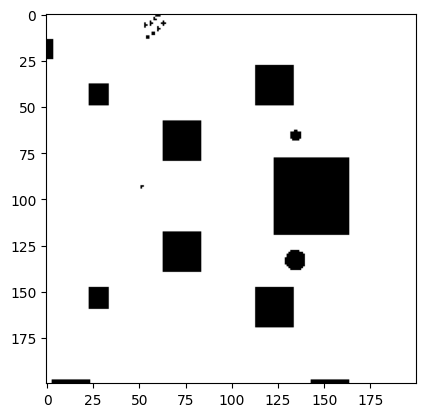

In [13]:
with open('occupancy_map.pickle', "rb") as f:
    data = pickle.load(f)

plt.imshow(data, cmap='Greys')

In [14]:
data_cost = create_cost_grid(data, [10, 5, 2.5, 1])
path = astar((100, 100), (190, 100), data, cost_grid=data_cost)

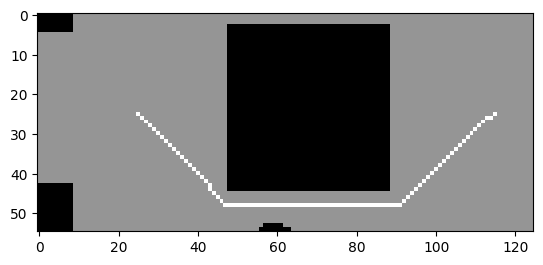

In [15]:
grid = copy.deepcopy(data)
for x, y in path:
    grid[y][x] = -1
plt.imshow(grid[75:130, 75:200], cmap='Greys')

In [16]:
def drawLine(start, end, grid):
    grid = copy.deepcopy(grid)

    x1, y1 = start
    x2, y2 = end

    dy = y2 - y1
    dx = x2 - x1

    length = math.sqrt(dy**2 + dx**2)
    vx = dx / length
    vy = dy / length

    for t in range(1, math.floor(length)):
        x = x1 + t * vx
        y = y1 + t * vy

        grid[math.floor(y), math.floor(x)] = 10
        grid[math.ceil(y), math.ceil(x)] = 10
    
    return grid

In [17]:
def isLineOfSightBlocked(start, end, grid, threshold):
    grid = copy.deepcopy(grid)

    x1, y1 = start
    x2, y2 = end

    dy = y2 - y1
    dx = x2 - x1

    length = math.sqrt(dy**2 + dx**2)
    vx = dx / length
    vy = dy / length

    print(x1, x2, y1, y2)
    print(dx, dy, math.floor(length))
    for t in range(1, math.floor(length)):
        x = round(x1 + t * vx)
        y = round(y1 + t * vy)

        if grid[y, x] >= threshold:
            return True
    
    return False


isLineOfSightBlocked((36, 56), (120, 143), data_cost, 5)

36 120 56 143
84 87 120


False

In [18]:
def line_of_sight_path(path, grid, threshold):
    new_path = []

    i = 0
    while i < len(path):
        start = path[i]
        new_path.append(start)
        for j in range(len(path) - 1, i, -1):
            end = path[j]
            if not isLineOfSightBlocked(start, end, grid, threshold):
                new_path.append(end)
                i = j
                break

        i += 1

    return new_path

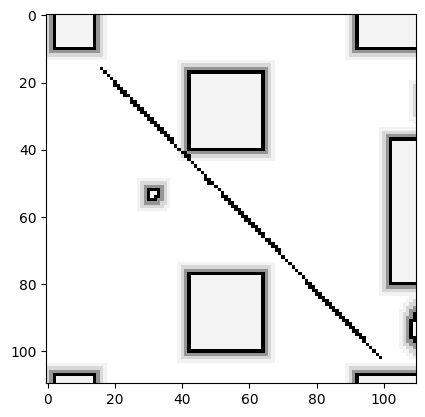

In [19]:
plt.imshow(drawLine((36, 56), (120, 143), data_cost)[40:150, 20:130], cmap='Greys')

In [20]:
grid = copy.deepcopy(data)
for x, y in path:
    grid[y][x] = -2

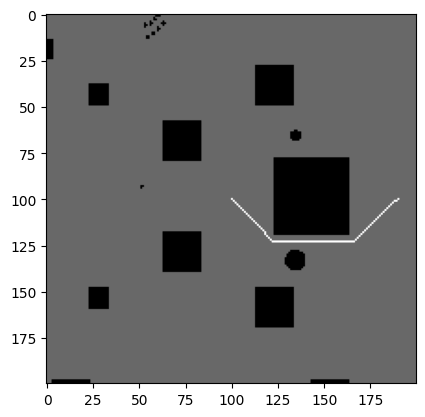

In [21]:
plt.imshow(grid, cmap='Greys')

91


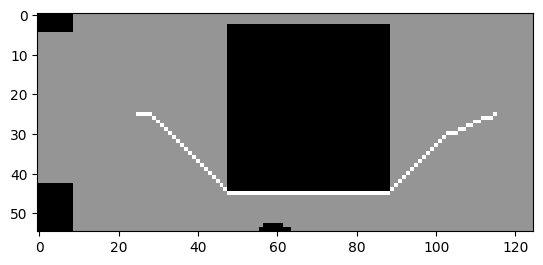

In [22]:
path = astar((100, 100), (190, 100), data)
print(len(path))

grid = copy.deepcopy(data)
for x, y in path:
    grid[y][x] = -1

plt.imshow(grid[75:130, 75:200], cmap='Greys')

92


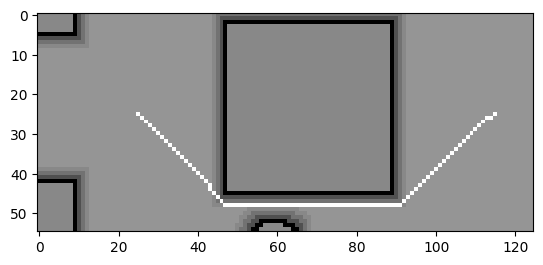

In [24]:
path = astar((100, 100), (190, 100), data, cost_grid=data_cost)
print(len(path))

grid = copy.deepcopy(data_cost)
for x, y in path:
    grid[y][x] = -10

plt.imshow(grid[75:130, 75:200], cmap='Greys')